In [151]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
from collections import defaultdict

In [3]:
from tqdm import tqdm

In [4]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.write_html('first_figure.html', auto_open=True)

Data Load & Preprocess

In [5]:
df_train = pd.read_csv('../data/train_users.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [213]:
df_train.gender.value_counts()

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

In [7]:
df_test = pd.read_csv('../data/test_users.csv')

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     62096 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.1+ MB


In [9]:
remove_columns = ['date_first_booking', 'country_destination']
# ignore_index
users = pd.concat([df_train.loc[:, ~df_train.columns.isin(remove_columns)], df_test.loc[:,~df_test.columns.isin(remove_columns)]], ignore_index = True)

In [10]:
df_train['booked'] = df_train.date_first_booking.notnull()

Age

In [11]:
y = users.age.dropna().value_counts()
x = y.index

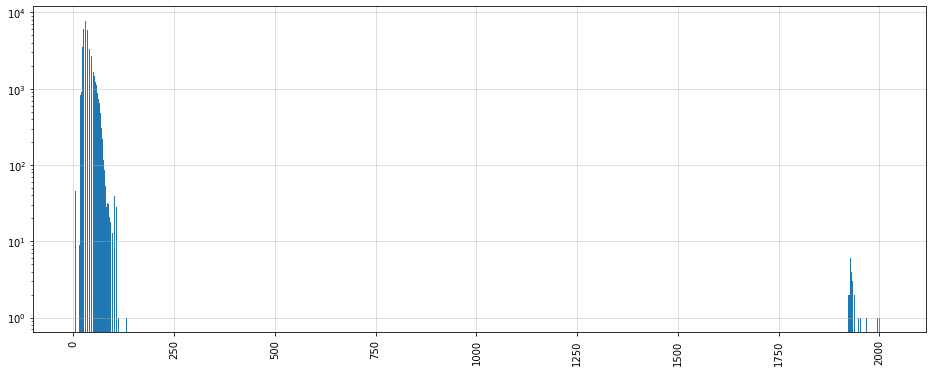

In [12]:
plt.figure(figsize=(16,6))
plt.bar(x, y)
plt.grid(alpha = 0.5)
plt.xticks(rotation = 90)
plt.yscale("log")

use of loc

In [225]:
len(df_train)

213451

In [224]:
df_train.loc[(df_train.age > 1000), 'age'].describe()

count     779.000000
mean     2011.097561
std        14.718288
min      1924.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

In [13]:
age_mask = users.age > 1000
users.loc[age_mask, 'age'] = 2015 - users.loc[age_mask, 'age']

In [14]:
users.loc[(users.age > 100) | (users.age < 18), 'age'] = -1
users.age.fillna(-1, inplace = True)

In [15]:
y = users.loc[users.age != -1, 'age'].value_counts()
x = y.index

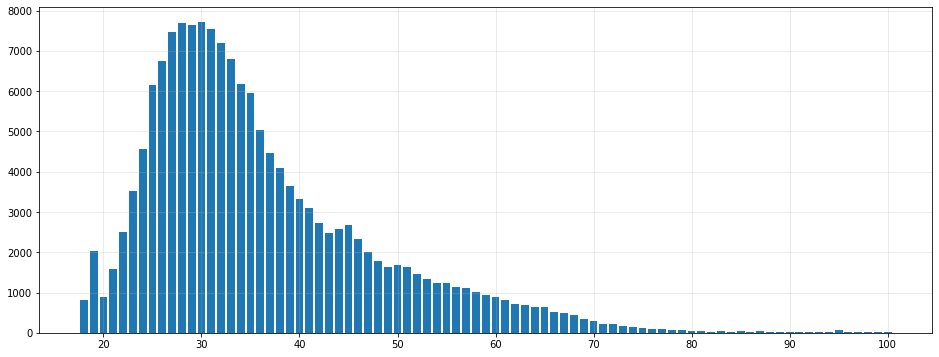

In [16]:
plt.figure(figsize=(16,6))
plt.bar(x, y)
plt.grid(alpha = 0.3)
plt.xticks([age for age in range(20,101,10)])
plt.show()

DatetimeIndex

In [17]:
#df_train['date_account_created'] = pd.to_datetime(date_account_created, format='%Y-%m-%d', errors='ignore')
users['account_created_year'] = pd.DatetimeIndex(users['date_account_created']).year
users['account_created_month'] = pd.DatetimeIndex(users['date_account_created']).month
users['account_created_day'] = pd.DatetimeIndex(users['date_account_created']).day

User Acquisition

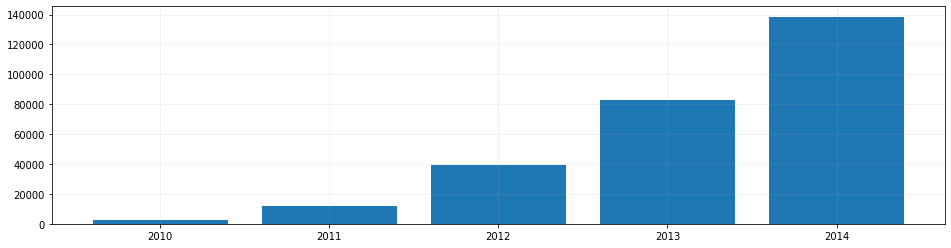

In [18]:
y = users.groupby('account_created_year').size()
x = y.index

plt.figure(figsize=(16,4))
plt.bar(x, y)
plt.grid(alpha = 0.2)
plt.show()

df.groupby().size()

In [19]:
year_month = users.groupby(['account_created_year', 'account_created_month']).size()

In [20]:
pd.crosstab(users.account_created_year, users.account_created_month)

account_created_month,1,2,3,4,5,6,7,8,9,10,11,12
account_created_year,,,,,,,,,,,,
2010,61,102,163,157,227,222,307,312,371,309,286,271
2011,316,362,491,577,744,822,993,1454,1864,1477,1386,1289
2012,1589,1789,2192,2589,3325,3867,4582,4476,4035,3828,3706,3484
2013,4418,4362,5421,5855,6721,6765,7950,8369,9125,7862,7751,8361
2014,11111,9967,12058,12689,14895,15746,21696,21626,18774,0,0,0


defaultdict(lambda :) -> lambda 작성하는 법

In [21]:
from collections import defaultdict

In [22]:
account_year_month = defaultdict(lambda: [-1 for x in range(13)])
for idx, val in zip(year_month.index, year_month):
    year = idx[0]
    month = idx[1]
    account_year_month[year][month] = val

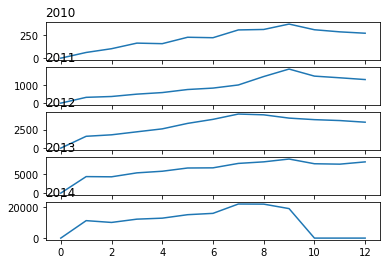

In [23]:
fig, axes = plt.subplots(len(account_year_month.keys()), 1)

for year, ax in zip(account_year_month.keys(), axes):
    
    vals = account_year_month[year]
    start = next(x for x, val in enumerate(vals) if val != -1)
    end = next(x for x, val in enumerate(vals[::-1]) if val != -1)
    
    start = start if start != 0 else 1
    end = 13 - end if end != 0 else 13

    ax.plot([m for m in range(len(vals))], vals)
    ax.set_title(year, loc = 'left')

In [24]:
def draw_line_plot(data):
    plt.figure(figsize=(16,8))
    for year in data.keys():
        start = next(x for x, val in enumerate(data[year]) if val != -1)
        end = next(x for x, val in enumerate(data[year][::-1]) if val != -1)

        start = start if start != 0 else 1
        end = 13 - end if end != 0 else 13
        plt.plot([x for x in range(start, end)], data[year][start:end], label = year)
    
    plt.xticks([x for x in range(1, 13)])
    plt.legend()
    plt.grid(alpha = 0.3)
    plt.show()

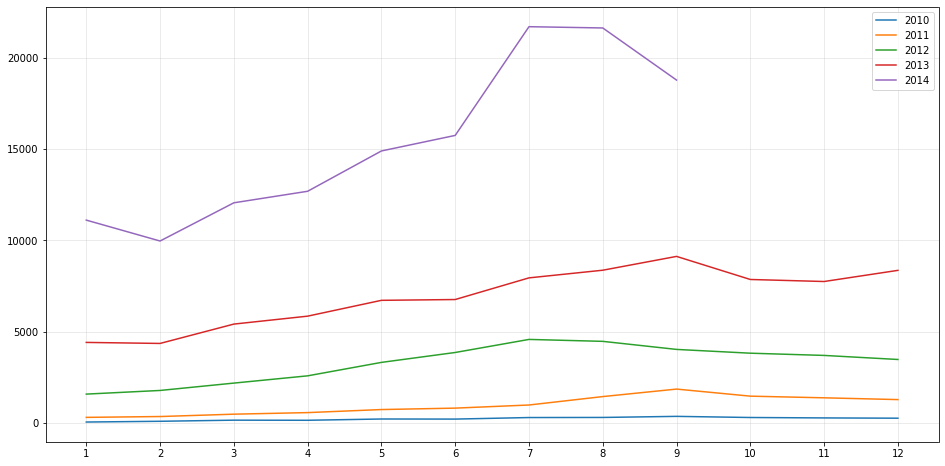

In [25]:
draw_line_plot(account_year_month)

In [26]:
activation = pd.DataFrame(users.groupby(['account_created_year', 'account_created_month']).size())
activation = activation.rename(columns = {0:'number_of_users'})

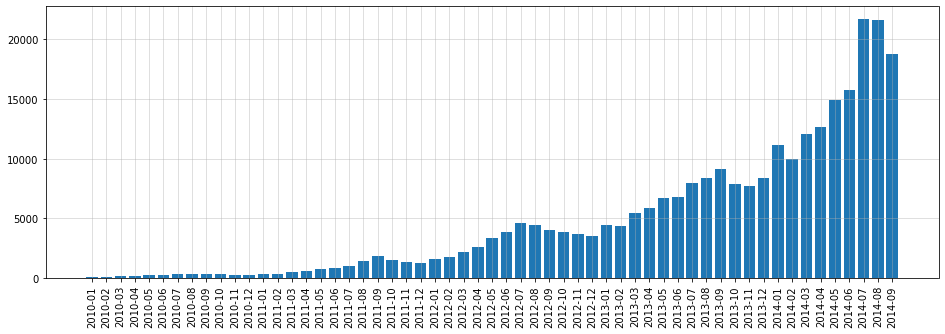

In [27]:
plt.figure(figsize=(16, 5))  
x = ['{}-{:02}'.format(y, m) for (y, m) in activation.index]
y = activation['number_of_users']
plt.bar(x, y)
plt.xticks(rotation = 90)
plt.grid(alpha = 0.5)
plt.show()

Affiliate Channel

In [28]:
users.affiliate_channel.unique()

array(['direct', 'seo', 'other', 'sem-non-brand', 'content', 'sem-brand',
       'remarketing', 'api'], dtype=object)

In [29]:
affi_channel_month = users.groupby(['account_created_year', 'account_created_month','affiliate_channel']).size().unstack()
affi_channel_month = affi_channel_month.fillna(0)

In [30]:
month_range = ['{}-{:02}'.format(y, m) for (y, m) in affi_channel_month.index]

In [31]:
channel_count = defaultdict(list)
for channel in affi_channel_month.columns:
    for m in range(len(affi_channel_month[channel])):
        count = affi_channel_month[channel][m]
        channel_count[channel].append(count) 

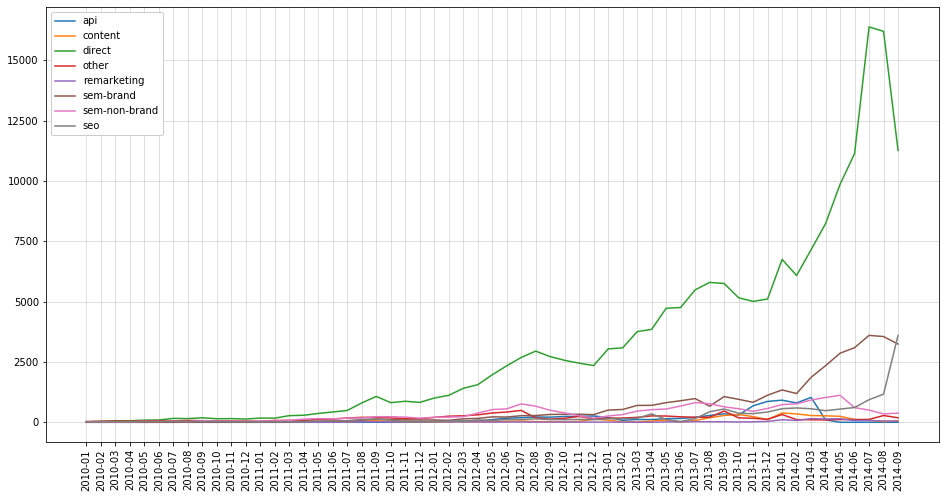

In [32]:
plt.figure(figsize=(16,8))
for channel in channel_count.keys():
    plt.plot(month_range, channel_count[channel], label = channel)
plt.xticks(rotation = 90)
plt.legend(framealpha=1, frameon=True);
plt.grid(alpha=0.5)
plt.show()

In [33]:
count_by_month = pd.DataFrame.from_dict(channel_count, orient = 'index', columns = month_range)

In [34]:
add = pd.DataFrame([])
for idx in range(1, len(month_range)):
    previous = month_range[idx - 1]
    current = month_range[idx]
    add = pd.concat([add, pd.DataFrame(count_by_month[current] / count_by_month[previous], columns = [current])], axis = 1)

In [35]:
def color_negative_red(value):
    """
    Colors elements in a dateframe
    green if positive and red if
    negative. Does not color NaN
    values.
    """
    
    if value == 0:
        color = 'black'
    elif value >= 1:
        color = 'red'
    else:
        color = 'blue'
    return 'color: %s'%color

In [36]:
add.replace(np.inf, np.nan).round(2).fillna(0).style.applymap(color_negative_red)

,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09
api,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0.8,2.42,0.83,2.35,1.5,1.13,1.16,0.95,1.15,1,1.07,0.76,0.41,1.43,0.96,1.33,1.07,1.29,1.38,1.24,0.85,2.28,1.27,1.06,0.88,1.28,0.1,0,0,0,0,0
content,0,11,1,0.82,0.67,1.5,1,0.67,2.5,0.67,0.8,2.38,0.95,0.83,0.67,1.6,1.06,1.18,2.3,1.37,0.62,0.44,0.94,0.69,2,1.41,0.58,1.5,1.44,1.33,0.52,1,0.48,3,3.23,0.71,0.17,1.2,2.83,1.84,0.1,8.11,2.58,1.5,1.13,0.74,0.45,3.6,0.9,0.8,0.96,0.92,0.47,0.69,0.36,2.07
direct,1.78,1.56,1,1.39,1.07,1.71,0.94,1.22,0.78,1.04,0.89,1.29,0.99,1.6,1.06,1.26,1.16,1.15,1.64,1.33,0.76,1.07,0.95,1.22,1.11,1.26,1.11,1.26,1.19,1.15,1.1,0.92,0.94,0.95,0.96,1.29,1.01,1.22,1.03,1.23,1.01,1.15,1.06,0.99,0.9,0.97,1.02,1.32,0.9,1.18,1.15,1.2,1.13,1.47,0.99,0.7
other,1.25,1.23,0.86,1.45,1.02,0.92,1.35,0.87,0.88,0.92,0.93,0.86,1.79,1.04,0.98,1.56,1.07,1.37,1.15,1,0.88,0.82,0.99,1.38,1.25,1.06,1.15,1.25,1.1,1.16,0.37,0.71,1.28,1.47,0.57,1.21,1.04,1.15,1.3,0.98,0.88,0.92,1,2.22,0.39,0.91,0.75,2.57,0.35,0.94,0.92,1.17,1,1.06,2.35,0.67
remarketing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.4,1.09,0.58,1,1,1.21,1.06,0.67,1.33,0.38,1.5,1.11,0.7,1.43,1,0.7,1,0.86,0.83,0,0,8.5,0.82,1.86,0.77,1,0.7,1.43,1.85,2.81,0.72,2.01,0.92,1.06,0.51,0.99,0.72,0.85
sem-brand,0,0,0,0,0,0,5,2.2,0.55,0.83,1.8,1.67,1.07,1.31,2.05,1.02,1.25,1.22,1.33,1.48,0.81,0.88,1,1.02,0.85,1.73,1.14,1.39,0.96,1.26,1.03,1.16,1.03,0.99,0.96,1.59,1.05,1.31,1.01,1.16,1.1,1.1,0.68,1.6,0.89,0.87,1.36,1.19,0.89,1.56,1.26,1.22,1.08,1.16,0.99,0.91
sem-non-brand,7,1.21,1.35,1.48,1,1.18,0.8,2.12,0.74,0.8,1.02,1.2,1.12,1.36,1.79,1.13,0.93,1.23,1.02,1.32,1,0.93,0.79,1.22,1.03,1.09,1.63,1.38,1.06,1.37,0.88,0.75,0.78,0.7,0.63,1.53,1.23,1.44,1.13,1.05,1.22,1.21,0.94,0.83,0.88,0.81,1.26,1.28,1.05,1.21,1.12,1.09,0.54,0.83,0.69,1.08
seo,1.5,3.67,0.77,2,0.74,1.52,0.95,0.92,1,0.76,1.12,0.57,1.5,1.04,0.8,2.25,1.2,1.11,1.88,1.21,0.67,0.29,0.85,1,2.57,0.71,2.36,0.77,1.46,1.04,1.23,0.8,0.96,1.11,0.92,1.32,1.03,1.11,2.1,0.33,0.28,4.61,2.86,1.26,0.68,0.95,1.19,1.33,1.05,0.94,0.86,1.14,1.12,1.53,1.24,3.09


In [37]:
users.first_device_type.value_counts(normalize = True)

Mac Desktop           0.385880
Windows Desktop       0.315547
iPhone                0.144491
iPad                  0.065455
Other/Unknown         0.040527
Android Phone         0.034324
Android Tablet        0.007614
Desktop (Other)       0.005469
SmartPhone (Other)    0.000693
Name: first_device_type, dtype: float64

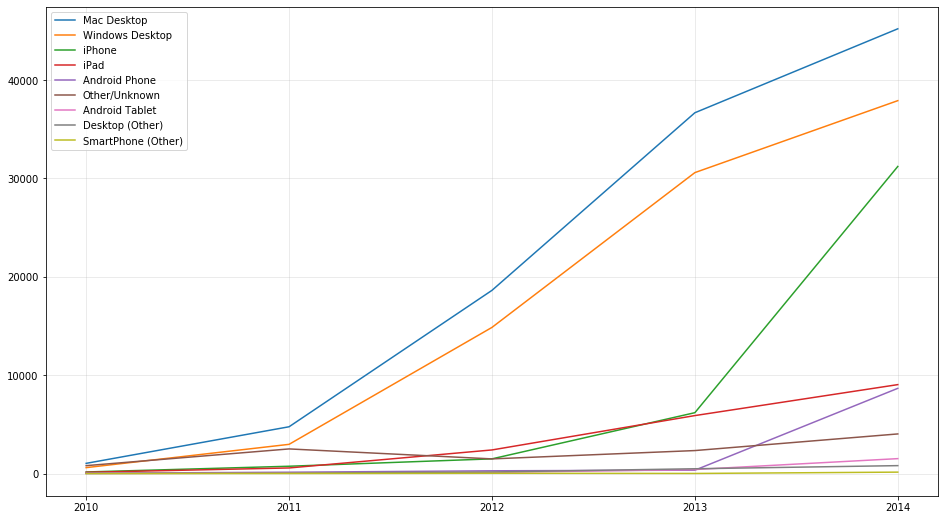

In [38]:
_year = users.account_created_year
_month = users.account_created_month

by_year = pd.crosstab(_year, users.first_device_type).T.sort_values(by = 2014, ascending = False).T

x = by_year.index
plt.figure(figsize=(16,9))
for device in by_year.columns:
    y = by_year[device]
    plt.plot(x, y, label = device)

plt.legend()
plt.xticks(x)
plt.grid(alpha = 0.3)
plt.show()

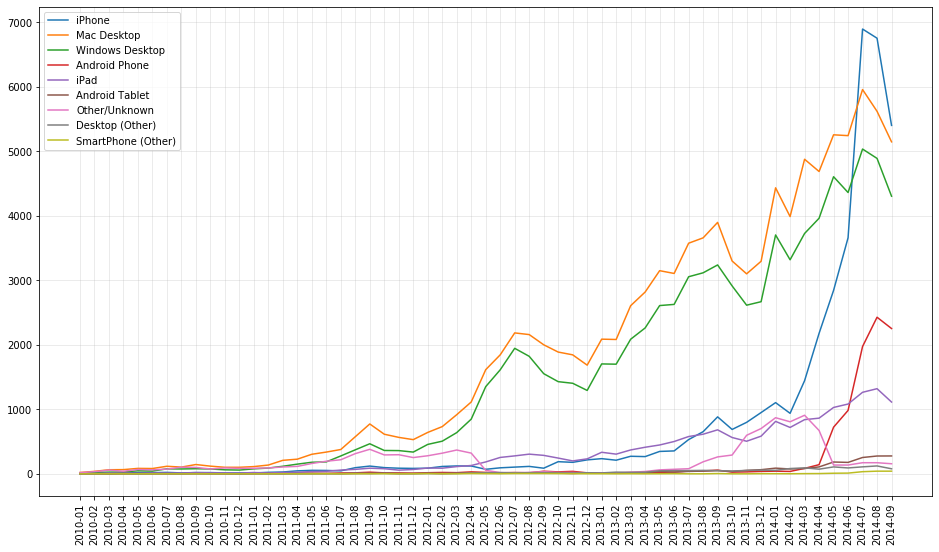

In [39]:
group_columns = ['account_created_year', 'account_created_month', 'first_device_type']
year_month_device = users.loc[:,group_columns].groupby(group_columns).agg(len).unstack().fillna(0)
by_year_month = year_month_device.T.sort_values(by = (2014, 9), ascending = False).T

plt.figure(figsize=(16,9))
x = ['{}-{:02}'.format(y, m) for (y, m) in by_year_month.index]
for device in by_year_month.columns:
    y = by_year_month[device]
    plt.plot(x, y, label = device)

plt.legend()
plt.xticks(x, rotation = 90)
plt.grid(alpha = 0.3)
plt.show()

In [47]:
users.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,account_created_year,account_created_month,account_created_day
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28


In [81]:
users.head(5)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,account_created_year,account_created_month,account_created_day
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011,12,5
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,9,14


Session Data

In [153]:
sessions = pd.read_csv('../data/sessions.csv')

In [154]:
sessions = sessions.rename(columns = {'user_id':'id'})

In [155]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
id               object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [156]:
sessions.isna().sum()

id                 34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [157]:
# remove rows NaN id
sessions = sessions.dropna(subset = ['id'])

In [158]:
len(sessions)

10533241

In [159]:
sessions.head(4)

,id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0


In [160]:
sessions['secs_elapsed'] = sessions['secs_elapsed'].fillna(0)

In [161]:
sessions.head(4)

,id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0


In [162]:
len(sessions)

10533241

In [163]:
sessions_ids = sessions.id.unique()

In [164]:
from_train = df_train.loc[df_train.id.isin(sessions_ids), ['id', 'date_account_created']]
from_test = df_test.loc[df_test.id.isin(sessions_ids), ['id', 'date_account_created']]
account_created_date = pd.concat([from_train, from_test], axis = 0)

In [165]:
sessions['cumulate_secs'] = sessions.groupby('id')['secs_elapsed'].cumsum()
sessions['cumulate_days'] = sessions['cumulate_secs']/60/60//24

In [166]:
from tqdm import tqdm

pd.DatetimeIndex -> list를 받음

pd.to_datetime

여기 차이 알고하는게 좋을 듯 (속도에 영향을 끼침)

In [167]:
account_date = defaultdict()
for _id, _date in zip(account_created_date['id'], account_created_date['date_account_created']):
    account_date[_id] = pd.to_datetime(_date)

account_date dictionary -> much faster

In [175]:
from tqdm import tqdm

In [176]:
def return_session_date(row):
    _id = row['id']
    _delta = row['cumulate_days']
    
    return account_date[_id] + pd.DateOffset(_delta)

tqdm.pandas()
sessions['session_date'] = sessions.loc[:, ['id', 'cumulate_days']].progress_apply(return_session_date, axis = 1)

/Users/keonhoseo/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

100%|██████████| 10533241/10533241 [08:24<00:00, 20886.89it/s]


In [89]:
"""
def return_session_date(row):
    _id = row['id']
    _delta = row['cumulate_days']
    
    _date = pd.DatetimeIndex(account_created_date[account_created_date.id == _id]['date_account_created'])
    _date += pd.DateOffset(_delta)
    
    return _date.date

#from tqdm import tqdm_notebook as tqdm
tqdm.pandas()
sessions['session_date'] = sessions.loc[:4, ['id', 'cumulate_days']].progress_apply(return_session_date, axis = 1)
"""

"\ndef return_session_date(row):\n    _id = row['id']\n    _delta = row['cumulate_days']\n    \n    _date = pd.DatetimeIndex(account_created_date[account_created_date.id == _id]['date_account_created'])\n    _date += pd.DateOffset(_delta)\n    \n    return _date.date\n\n#from tqdm import tqdm_notebook as tqdm\ntqdm.pandas()\nsessions['session_date'] = sessions.loc[:4, ['id', 'cumulate_days']].progress_apply(return_session_date, axis = 1)\n"

In [178]:
sessions.head(4)

,id,action,action_type,action_detail,device_type,secs_elapsed,cumulate_secs,cumulate_days,session_date
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0,319.0,0.0,2014-01-01
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0,68072.0,0.0,2014-01-01
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0,68373.0,0.0,2014-01-01
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0,90514.0,1.0,2014-01-02


In [179]:
booked_users_id = df_train.loc[pd.notnull(df_train.date_first_booking), 'id']

In [180]:
booked_users = sessions.loc[sessions.id.isin(booked_users_id)]
unbooked_users = sessions.loc[~sessions.id.isin(booked_users_id)]

In [181]:
mask = df_train.date_account_created > df_train.date_first_booking
book_first = df_train.loc[(df_train.id.isin(booked_users_id)) & mask].id
sessions.loc[sessions.id.isin(book_first)]

,id,action,action_type,action_detail,device_type,secs_elapsed,cumulate_secs,cumulate_days,session_date


In [182]:
len(book_first)

29

In [198]:
sessions.cumulate_days.quantile([.15, .2, .5, .8, .99])

0.15      1.0
0.20      2.0
0.50     11.0
0.80     32.0
0.99    122.0
Name: cumulate_days, dtype: float64

bringing cumulate_days up is required

In [186]:
_retention = []
_retention_days = sessions.groupby('id')['cumulate_days'].agg(['max'])
for day in range(0, 121):
    _retention.append(1 - ((_retention_days < day).sum() / len(_retention_days)))

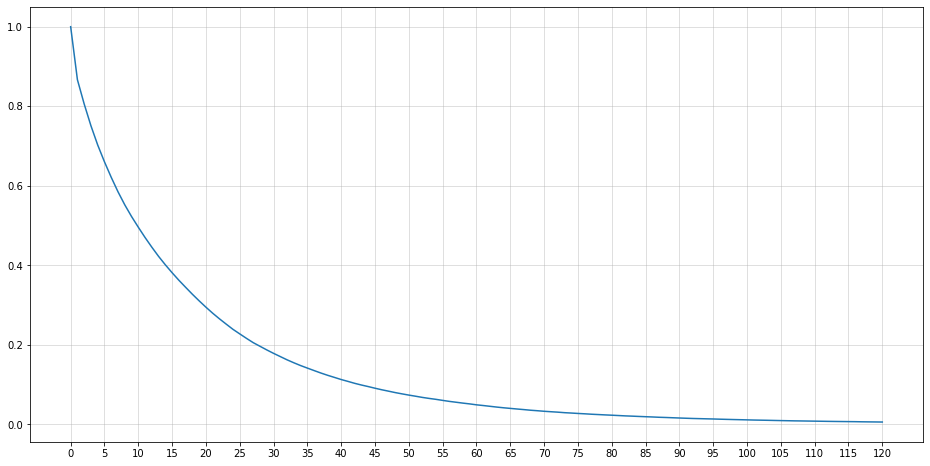

In [187]:
plt.figure(figsize=(16,8))
plt.plot(range(0, 121), _retention)
#plt.legend()
plt.xticks(range(0,121, 5))
plt.grid(alpha = 0.5)

In [188]:
booked_users_elapsed = booked_users.groupby('id')['secs_elapsed'].agg(['sum', ('day', lambda x: np.sum(x)/60/60/24)])
unbooked_users_elapsed = unbooked_users.groupby('id')['secs_elapsed'].agg(['sum', ('day', lambda x: np.sum(x)/60/60/24)])

In [189]:
_booked = []
_unbooked = []
for day in range(0, 121):
    _booked.append(1 - (len(booked_users_elapsed.loc[booked_users_elapsed.day < day]) / len(booked_users_elapsed)))
    _unbooked.append(1 - (len(unbooked_users_elapsed.loc[unbooked_users_elapsed.day < day]) / len(unbooked_users_elapsed)))

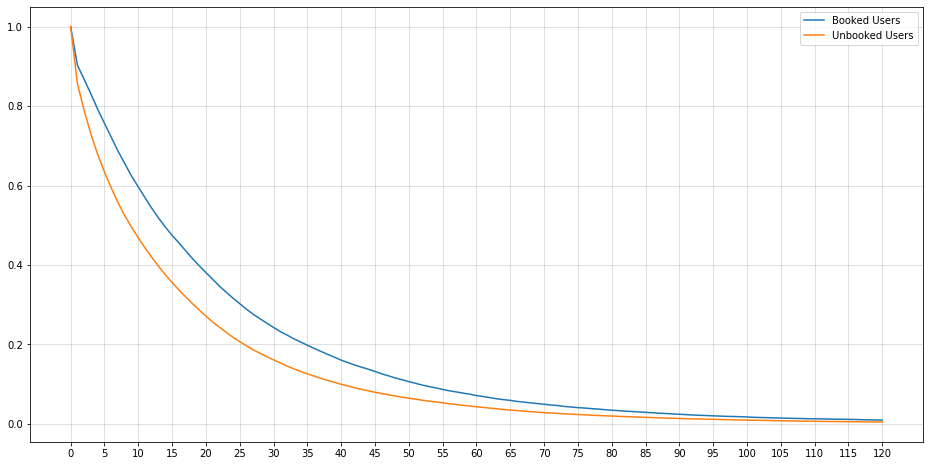

In [190]:
plt.figure(figsize=(16,8))
plt.plot(range(0, 121), _booked, label = 'Booked Users')
plt.plot(range(0, 121), _unbooked, label = 'Unbooked Users')
plt.legend()
plt.xticks(range(0,121, 5))
plt.grid(alpha = 0.5)

In [191]:
retention = pd.concat([booked_users_elapsed, unbooked_users_elapsed])

In [199]:
bottom_20 = retention.loc[retention.day <= 2].index
top_20 = retention.loc[retention.day >= 32].index

In [200]:
print(len(bottom_20))
print(len(top_20))

26342
21965


In [203]:
b_20 = sessions.loc[sessions.id.isin(bottom_20)].groupby(['id','action'])['action_type'].agg('count')
b_20_actions = defaultdict(int)
for idx, count in zip(b_20.index, b_20):
    b_20_actions[idx[1]] += count

In [204]:
t_20 = sessions.loc[sessions.id.isin(top_20)].groupby(['id','action'])['action_type'].agg('count')
t_20_actions = defaultdict(int)
for idx, count in zip(t_20.index, t_20):
    t_20_actions[idx[1]] += count

In [205]:
sum(b_20_actions.values())

225236

In [206]:
sum(t_20_actions.values())

4280017

In [207]:
total = sum(b_20_actions.values())
for (k, v) in sorted(b_20_actions.items(), key = lambda k_v:k_v[1], reverse = True):
    print(k, round(v / total, 7))

show 0.1643121
header_userpic 0.0822204
active 0.0682795
index 0.0612957
create 0.0596574
dashboard 0.0533352
personalize 0.0493038
search 0.0481939
update 0.037676
search_results 0.0304125
authenticate 0.0281083
notifications 0.0269584
ajax_refresh_subtotal 0.0247429
reviews 0.0224875
social_connections 0.0184473
collections 0.0172974
ask_question 0.0168357
confirm_email 0.0162807
similar_listings 0.0161253
callback 0.0110551
unavailabilities 0.0093413
edit 0.0087997
impressions 0.0076631
manage_listing 0.0060426
listings 0.0047728
travel_plans_current 0.0046174
recommended_listings 0.0039736
custom_recommended_destinations 0.0038759
show_personalize 0.0038493
identity 0.0037294
cancellation_policies 0.0036184
payment_instruments 0.0035918
signup_login 0.0034275
populate_help_dropdown 0.0033831
set_user 0.0033742
ajax_check_dates 0.0033476
payment_methods 0.0031833
click 0.0026683
open_graph_setting 0.002615
login 0.0025884
settings 0.0025351
qt2 0.0025307
new 0.0024818
edit_verificat

In [208]:
sessions.loc[sessions.action == 'similar_listings', 'action_detail'].value_counts()

similar_listings    363423
Name: action_detail, dtype: int64

In [209]:
total = sum(t_20_actions.values())
for (k, v) in sorted(t_20_actions.items(), key = lambda k_v:k_v[1], reverse = True):
    print(k, round(v / total, 7))

show 0.2338091
index 0.1008804
personalize 0.085812
search_results 0.0851616
ajax_refresh_subtotal 0.0600192
similar_listings 0.0463293
search 0.0459251
update 0.0406625
social_connections 0.0332735
reviews 0.0294249
active 0.015127
edit 0.0119046
collections 0.0117411
dashboard 0.0115102
create 0.0109759
qt2 0.0104259
header_userpic 0.0082184
unavailabilities 0.007467
ajax_check_dates 0.0060976
show_personalize 0.0060677
calendar_tab_inner2 0.0059301
identity 0.0058325
listings 0.0056577
notifications 0.0045362
requested 0.0041526
ajax_lwlb_contact 0.003924
ask_question 0.003917
other_hosting_reviews_first 0.0038834
travel_plans_current 0.0038649
edit_verification 0.0038203
confirm_email 0.0037792
complete_status 0.0034757
manage_listing 0.0031269
recommendations 0.0029339
ajax_photo_widget_form_iframe 0.002932
authenticate 0.002686
click 0.0025491
payment_instruments 0.0023217
impressions 0.0021946
payment_methods 0.0020488
verify 0.0019177
message_to_host_focus 0.0018787
profile_pic

In [210]:
action_count = sessions.groupby(['id', 'action'])['action_type'].agg('count')

In [78]:
action_count.unstack().loc[action_count.unstack()['confirm_email'] > 1]['confirm_email'].mean()

2.4192238267148016

In [79]:
action_count.unstack().loc[action_count.unstack()['confirm_email'] > 1]['confirm_email'].max()

18.0

MAU (Monthly Active Users)

In [97]:
daily_access = sessions.groupby(['id', 'session_date'])['action'].agg('nunique')

In [98]:
daily_access.reset_index()['session_date']

0         2014-05-14
1         2014-05-15
2         2014-05-16
3         2014-05-23
4         2014-05-24
             ...    
1335185   2014-06-11
1335186   2014-06-12
1335187   2014-06-13
1335188   2014-06-14
1335189   2014-06-15
Name: session_date, Length: 1335190, dtype: datetime64[ns]

DAU

In [99]:
dau = daily_access.reset_index()['session_date'].value_counts()

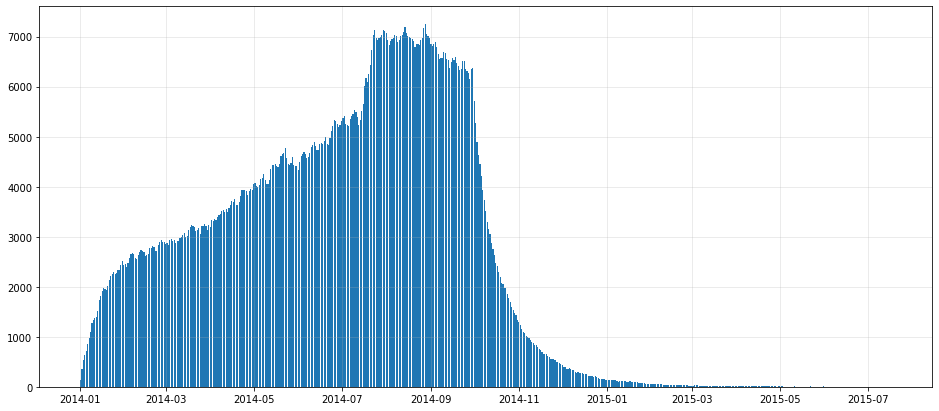

In [100]:
plt.figure(figsize=(16,7))
plt.bar(dau.index, dau)
plt.grid(alpha = 0.3)
plt.show()

In [131]:
_year = pd.DatetimeIndex(daily_access.reset_index()['session_date']).year
_month = pd.DatetimeIndex(daily_access.reset_index()['session_date']).month

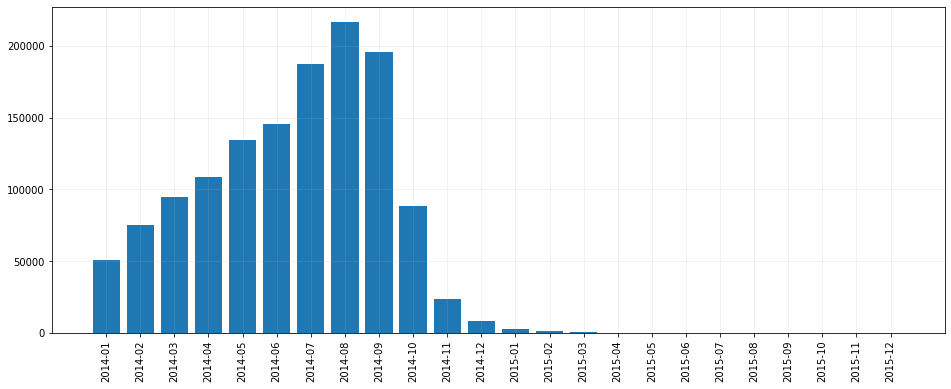

In [145]:
y = pd.crosstab(_year, _month).stack()
x = ['{}-{:02}'.format(year, month) for (year, month) in y.index]

plt.figure(figsize=(16,6))
plt.bar(x, y)
plt.xticks(rotation = 90)
plt.grid(alpha = 0.2)
plt.show()

In [286]:
t = sessions.action.value_counts()
for idx, c in zip(t.index, t):
    print(idx, c)

show 2758985
index 841071
search_results 723124
personalize 704782
search 533833
ajax_refresh_subtotal 486414
similar_listings 363423
update 362708
social_connections 337764
reviews 319318
active 187370
similar_listings_v2 168457
lookup 161422
create 155233
dashboard 152515
header_userpic 141315
collections 124067
edit 108927
campaigns 104647
track_page_view 80949
unavailabilities 77985
qt2 64585
notifications 59198
confirm_email 58557
requested 57020
identity 53550
ajax_check_dates 52426
show_personalize 50353
ask_question 43972
listings 43515
authenticate 42841
calendar_tab_inner2 41947
travel_plans_current 38139
edit_verification 33374
ajax_lwlb_contact 33345
other_hosting_reviews_first 30996
recommendations 30497
impressions 27746
manage_listing 26267
click 25456
complete_status 24667
ajax_photo_widget_form_iframe 24425
payment_instruments 23461
message_to_host_focus 21629
verify 21324
payment_methods 19736
cancellation_policies 19220
callback 19053
settings 16740
custom_recommende

In [45]:
gender_destination = pd.crosstab(df_train.gender, df_train.country_destination, normalize = True)
gender_destination['SUM'] = gender_destination.agg(np.sum, axis = 1)
gender_destination.loc['SUM'] = gender_destination.sum()
gender_destination

country_destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other,SUM
gender,,,,,,,,,,,,,
-unknown-,0.000670,0.002300,0.001331,0.003350,0.008025,0.003551,0.004872,0.312343,0.001063,0.000323,0.094209,0.016252,0.448290
FEMALE,0.000970,0.002132,0.001677,0.003996,0.009192,0.004127,0.005111,0.145457,0.001190,0.000365,0.106319,0.014804,0.295342
MALE,0.000881,0.002235,0.001949,0.003172,0.006254,0.003195,0.003275,0.125176,0.001302,0.000323,0.091154,0.016130,0.255047
OTHER,0.000005,0.000023,0.000014,0.000019,0.000061,0.000014,0.000023,0.000497,0.000014,0.000005,0.000543,0.000103,0.001321
SUM,0.002525,0.006690,0.004971,0.010536,0.023532,0.010888,0.013282,0.583473,0.003570,0.001017,0.292226,0.047290,1.000000


In [46]:
destination_by_gender = pd.DataFrame([])
for gender in df_train.gender.unique():
    gender_mask = df_train.gender == gender
    destination_by_gender = destination_by_gender.append(df_train.loc[gender_mask, 'country_destination'].value_counts(normalize = True).rename(gender))
destination_by_gender['SUM'] = destination_by_gender.agg(np.sum, axis = 1)

In [47]:
destination_by_gender

,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other,SUM
-unknown-,0.001494,0.005131,0.002968,0.007472,0.017902,0.007922,0.010869,0.696744,0.002372,0.000721,0.210152,0.036253,1.0
MALE,0.003453,0.008762,0.007641,0.012436,0.024522,0.012528,0.012840,0.490797,0.005107,0.001267,0.357403,0.063244,1.0
FEMALE,0.003284,0.007218,0.005679,0.013531,0.031123,0.013975,0.017306,0.492505,0.004029,0.001237,0.359988,0.050126,1.0
OTHER,0.003546,0.017730,0.010638,0.014184,0.046099,0.010638,0.017730,0.375887,0.010638,0.003546,0.411348,0.078014,1.0


In [49]:
gender_country = defaultdict(list)
for gender in df_train.gender.unique():
    gender_country[gender] = df_train.loc[df_train.gender == gender, 'country_destination'].value_counts()

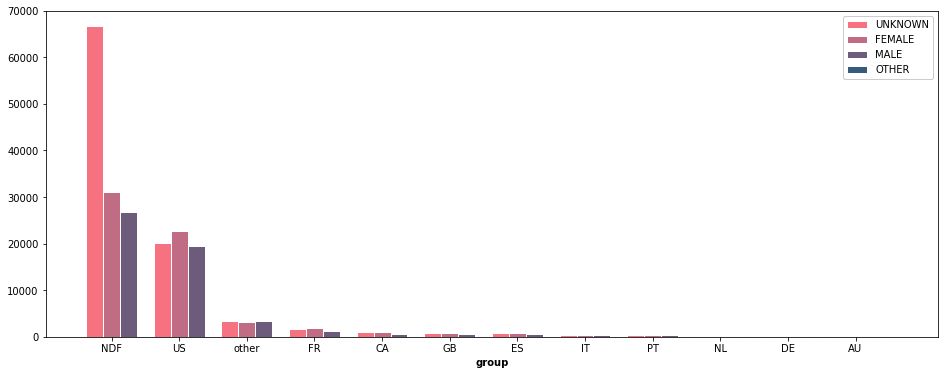

In [50]:
barWidth = 0.25

colors = ['#0F4C81', '#F5B895', '#77202F', '#E38690']

plt.figure(figsize=(16,6))

r1 = np.arange(len(gender_country['-unknown-']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, gender_country['-unknown-'], color='#F67280', width=barWidth, edgecolor='white', label='UNKNOWN')
plt.bar(r2, gender_country['FEMALE'], color='#C06C84', width=barWidth, edgecolor='white', label='FEMALE')
plt.bar(r3, gender_country['MALE'], color='#6C5B7B', width=barWidth, edgecolor='white', label='MALE')
plt.bar(r4, gender_country['OTHER'] , color='#355C7D', width=barWidth, edgecolor='white', label='OTHER')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(gender_country['FEMALE']))], df_train.country_destination.unique())
plt.legend(framealpha=1, frameon=True);
plt.show()

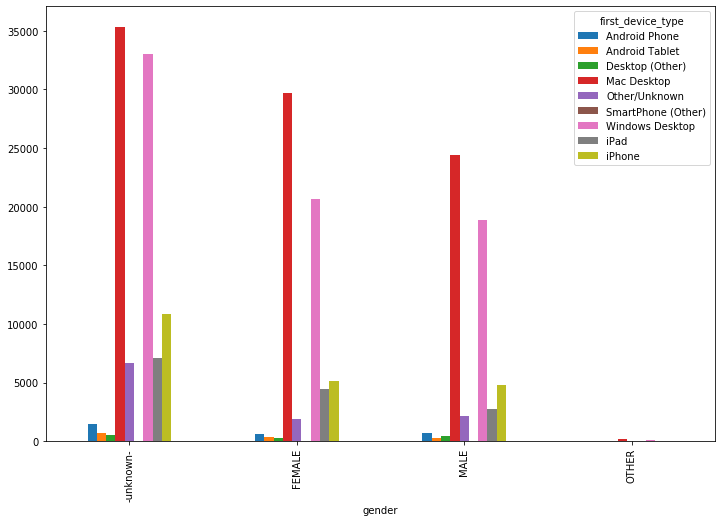

In [51]:
pd.crosstab(df_train.gender, df_train.first_device_type).plot.bar()

In [147]:
booked_mask = (df_train.date_first_booking.notnull())
age_mask = (df_train.age != -1)

In [148]:
df_train.loc[booked_mask & age_mask]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,booked
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,True
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,True
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,True
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,True
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213415,7plqriggxp,2014-06-30,20140630230136,2014-06-30,-unknown-,55.0,basic,0,en,sem-brand,google,omg,Web,Android Tablet,IE,FR,True
213439,msucfwmlzc,2014-06-30,20140630234729,2015-03-16,MALE,43.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Firefox,US,True
213441,omlc9iku7t,2014-06-30,20140630235151,2014-08-13,FEMALE,34.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,Chrome,ES,True
213443,0k26r3mir0,2014-06-30,20140630235340,2014-07-13,FEMALE,36.0,basic,0,en,sem-brand,google,linked,Web,Mac Desktop,Safari,US,True


In [52]:
#gender_mask = (df_train.gender == '-unknown-')
age_mask = (df_train.age != -1)

In [55]:
dates = df_train.loc[df_train.date_first_booking.notnull()]
_delta = (pd.DatetimeIndex(dates['date_first_booking']) - pd.DatetimeIndex(dates['date_account_created'])).days
_delta = [day for day in _delta if day >= 0]

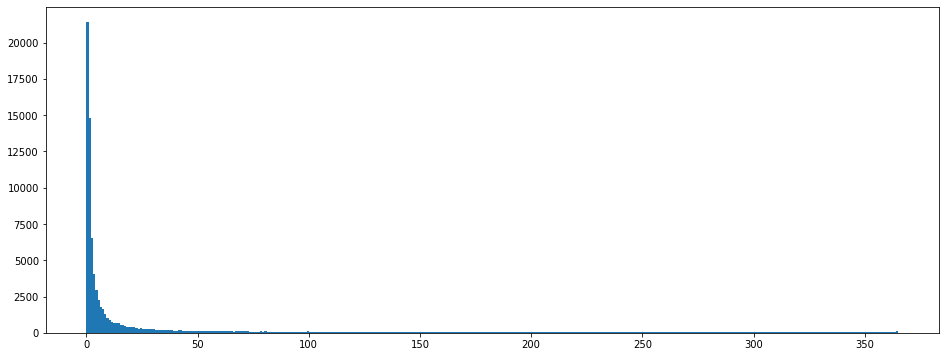

In [56]:
plt.figure(figsize=(16,6))
plt.hist(_delta, bins = 365)
plt.show()

Which of these channels are bringing you most conversions?

In [177]:
conversion_rate = df_train.groupby(['affiliate_channel', 'booked']).size() / df_train.groupby(['affiliate_channel']).size()

In [150]:
conversion_rate.unstack().sort_values(by = True, ascending = False)

booked,False,True
affiliate_channel,,
seo,0.543461,0.456539
direct,0.568727,0.431273
sem-brand,0.574045,0.425955
other,0.598259,0.401741
sem-non-brand,0.620569,0.379431
api,0.658994,0.341006
remarketing,0.664234,0.335766
content,0.858663,0.141337
